# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [39]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
np.random.seed(0)


## Load *Dataset*
Load data from the given pickle file

In [40]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/gdrive')

# load the data set
with open('/content/gdrive/My Drive/CNN/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['X']
y_prev = data['y']

# Changed normalisation
std_vec=np.std(X,axis=0)
std_vec[np.where(std_vec==0)]=1e-22
X=(X-np.mean(X,axis=0))/std_vec

# Other method of normalisation in case previous give some error but weights will be different
# X=(X-np.mean(X))/np.std(X)

# Below step is to make only element corresponding to lable number 1, rest 0, now y has dimension 60000*10
# This for loop will take constant time only (used just once) thus vectorising it won't give much time benefit  
table = np.zeros((y_prev.shape[0], 10))
for i in range(y_prev.shape[0]):
  table[i][int(y_prev[i][0])] = 1
y=table  

# Split into X_train, y_train, X_test, y_test

# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Labels:
[[0 9 9 2]
 [8 8 4 1]
 [6 5 1 3]
 [6 8 1 5]]


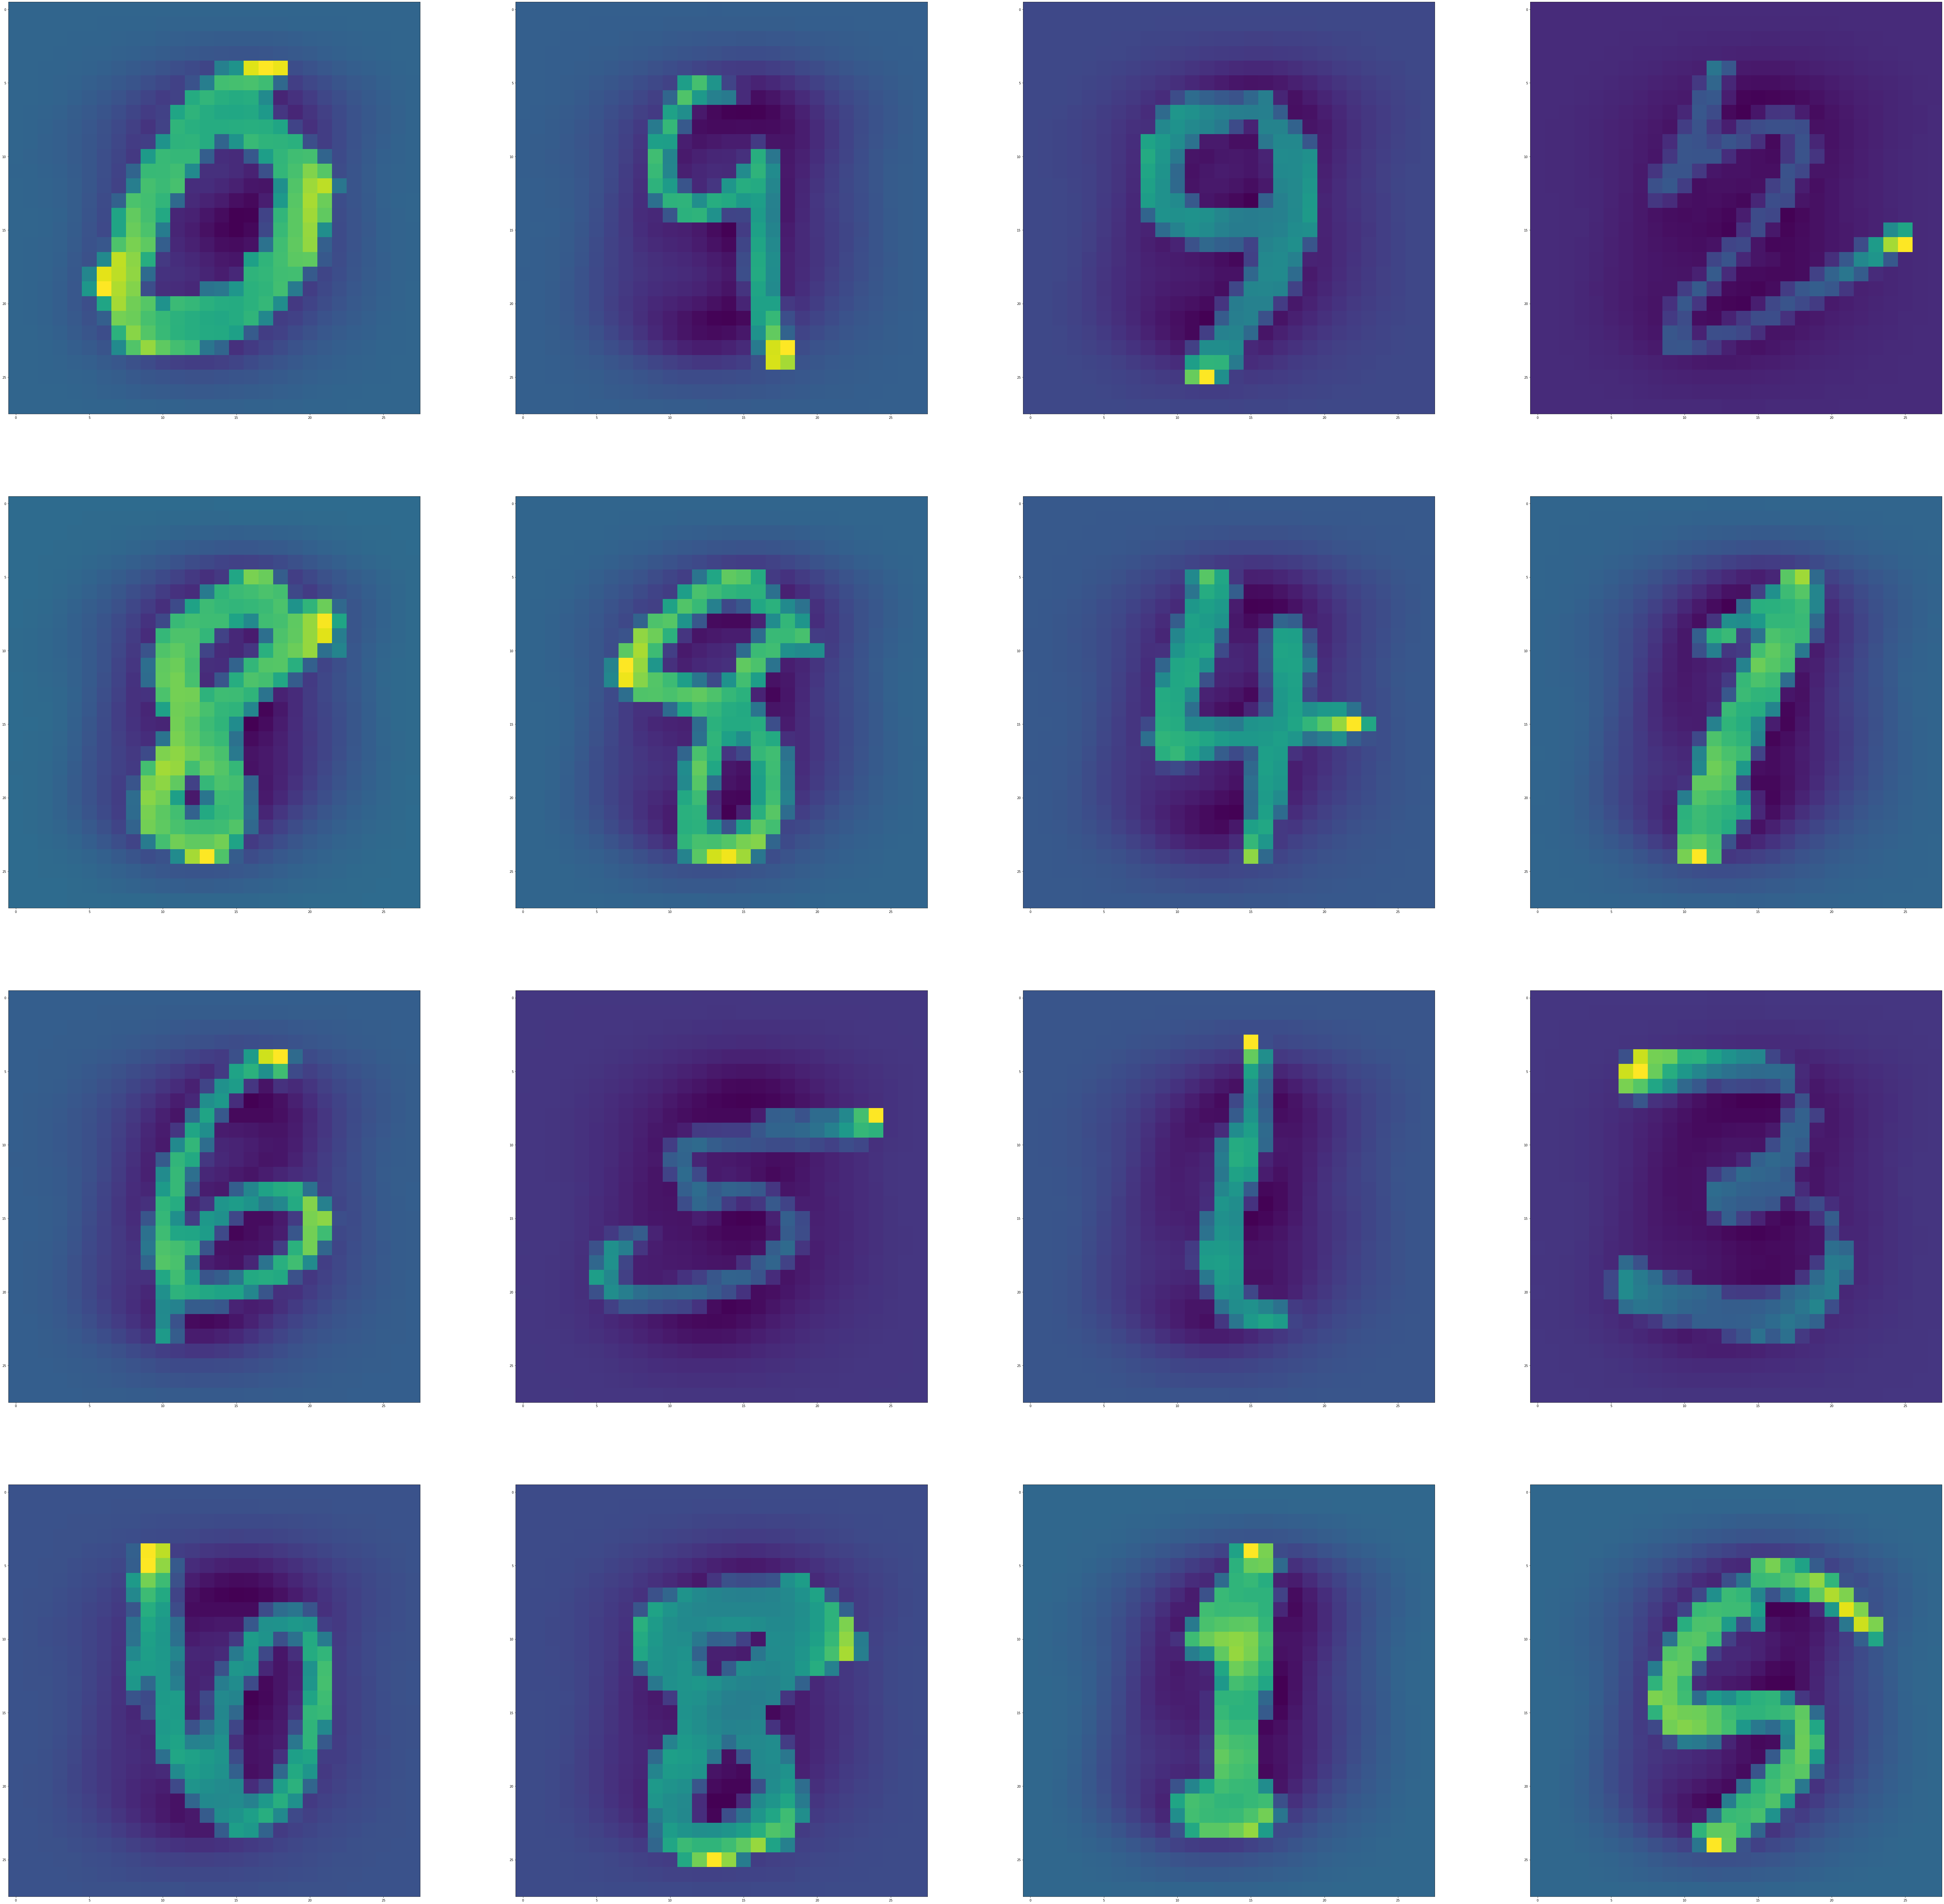

In [41]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

random_indices = np.random.choice(X.shape[0], size=16, replace=False)
random_images = X[random_indices, :]
random_images_labels = y_prev[random_indices, :]

# Create plt plot:
fig, axes = plt.subplots(4, 4, figsize=(4*28, 4*28))

for i in range(16):
    y_position = i % 4
    x_position = i // 4

    plt_image=np.reshape(random_images[i,:], (28, 28))
    axes[x_position, y_position].imshow(plt_image)

print("Labels:")
print(np.reshape(random_images_labels,(4,4)))

## Building up parts of our classifier

**Activation functions**

In [42]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return (np.maximum(0,z))

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
    return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)
    
def derivative_relu(z):
       return 1 * (z > 0) 


**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [43]:
def init_params(n1,n2,n3,batch):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """

    #n1,n2,n3 are sizes of layer
    return {'W1':np.random.normal(0, 1,size=(n1,n2)),'W2':np.random.normal(0, 1, size=(n2,n3)),'b1':np.zeros((n2,)),'b2':np.zeros((n3,))}

**Forward Propagation**

In [44]:
def forward_propg(X, weights_biases):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    
    z1=np.matmul(X,weights_biases['W1'])+weights_biases['b1']
    a1=relu(z1)
    z2=np.matmul(a1,weights_biases['W2'])+weights_biases['b2']
    a2=softmax(z2)

    return {'z1':z1,'a1':a1,'z2':z2,'a2':a2}


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [45]:
def backward_propg(weights, X, y, out_forwarding):
    """
    should update the weights and return updated weights
    """    
    # TRY 1
    # This try did not work sadly
    # I tried to implement square mean loss function here using scores and labels

    # y_1=np.zeros((len(y),10))
    # for i in range(128):
    #   y_1[i,y[i]]=1

    # z_1=2*(out_forwarding['a2'].T-y_1)/(out_forwarding['a2'].shape[1])*derivative_softmax(out_forwarding['z2'].T)
    
    # grad_W2=np.matmul(out_forwarding['a1'],z_1).T
    # grad_b2=z_1.T
    # z_2=((weights['W2'].T).dot(z_1.T)).T*derivative_sigmoid(out_forwarding['z1'].T)
    
    # grad_W1=np.matmul(X,z_2).T    
    # grad_b1=z_2.T
    
    #TRY 2
    # In this try I have used and implemented the cross entropy loss function
    
    z1 = out_forwarding['a2'] - y
    z2 = 1/(len(y))*z1

    #no regularisation
    grad_W2 = np.dot(z2.T,out_forwarding['a1']).T
    grad_W1 = np.dot((np.dot((z2),weights['W2'].T) * derivative_relu(out_forwarding['z1'])).T,X).T
    grad_b2 = np.sum(z2,axis = 0)
    grad_b1 = np.sum(np.dot((z2),weights['W2'].T) * derivative_relu(out_forwarding['z1']),axis = 0)
        

    return {'g_W2':grad_W2,'g_b2':grad_b2,'g_W1':grad_W1,'g_b1':grad_b1}  

In [46]:
def cost_func(weight,y,params):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """

    #no regularisation for now
    #cross entropy loss function
    loss=-np.log(np.trace(np.matmul(y,params.T)))
    return loss



## Integrate everything

In [47]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """

    input_nodes=784
    output_nodes=10
    batch=150
    # mini batch gradient descent

    # initialize weights.
    weights_biases=init_params(input_nodes,hidden_nodes,output_nodes,batch)

    for i in range(epochs):
        # forward propagation
        
        ind=np.random.randint(0,X_train.shape[0]-1,size=(batch))
        X_curr=X_train[ind]
        
        out_forwarding=forward_propg(X_curr, weights_biases)

        #print cost at every 100 or so iterations
        if(i%100==0):
          print(cost_func(weights_biases,y_train[ind],out_forwarding['a2']))

        # backward propagation
        grad_weights_biases=backward_propg(weights_biases, X_curr, y_train[ind], out_forwarding)

        weights_biases['W1']=weights_biases['W1']-lr*grad_weights_biases['g_W1']
        weights_biases['W2']=weights_biases['W2']-lr*grad_weights_biases['g_W2']
        weights_biases['b1']=weights_biases['b1']-lr*grad_weights_biases['g_b1']
        weights_biases['b2']=weights_biases['b2']-lr*grad_weights_biases['g_b2']
    
    return weights_biases        

updated_weights_biases=train(X_train, y_train, 128, 50000, 0.005)

-2.4641926639481464
-4.153697965990686
-4.643268318299894
-4.69164386949391
-4.718312791836069
-4.729292952769058
-4.727370662897869
-4.854833699972244
-4.748732246755226
-4.89339830983055
-4.787796217244083
-4.825743456557824
-4.851999438076511
-4.7929726496118965
-4.791570729550295
-4.766149992627881
-4.802841808666931
-4.942855528740458
-4.901521357324897
-4.872385614372721
-4.872195383132486
-4.8770966791587655
-4.882718782956913
-4.835515392592852
-4.83571117686907
-4.837986146241226
-4.828250562810113
-4.887077148004153
-4.875507069357234
-4.887440154862274
-4.848631109856844
-4.889093334399991
-4.813917916568569
-4.854636865501268
-4.9046764141577395
-4.875773064300093
-4.90293826969292
-4.90092972499604
-4.860095316908711
-4.909008824422006
-4.877440172889476
-4.8765997041028095
-4.854983198957455
-4.893481129591615
-4.941631681322766
-4.890243216356948
-4.83069048571037
-4.905049877167618
-4.879474446401904
-4.887878499568135
-4.929245750513012
-4.88794552920148
-4.84853941417

In [48]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    scores=forward_propg(X, updated_weights)
    return np.argmax(scores['a2'],axis=1)

In [49]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    frac_correct = np.mean(predictions == y)
    return 100*frac_correct

table = np.zeros(y_test.shape[0])

for i in range(y_test.shape[0]):
  table[i]= np.argmax(y_test[i])

y_test_1=table

table = np.zeros(y_train.shape[0])

for i in range(y_train.shape[0]):
  table[i]= np.argmax(y_train[i])

y_train_1=table

print(accuracy(predict(X_train,updated_weights_biases),y_train_1))
print(accuracy(predict(X_test,updated_weights_biases),y_test_1))

92.38444444444444
90.05333333333333


### Save as pickle

In [50]:
import pickle
import random
from google.colab import files

roll_num = "200260047" # enter ldap
hidden_dim = 128 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': updated_weights_biases['W1'], # layer 0 weight (784, z)
    'layer_0_bias': np.reshape(updated_weights_biases['b1'],(hidden_dim, 1)), # layer 0 bias (z, 1)
    'layer_1_wt': updated_weights_biases['W2'], # layer 1 weight (z, 10)
    'layer_1_bias': np.reshape(updated_weights_biases['b2'],(10, 1)) # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>